In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.ticker as ticker
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ephem
from datetime import datetime
import pytz
import matplotlib.cm as cm
import dask
from dask.distributed import Client, LocalCluster
from pymannkendall import seasonal_test
from dask import delayed, compute
from pymannkendall import seasonal_sens_slope
import calendar

---
---
## 1. Load and prepare data

In [2]:
# Specify towers and variables of interest
towers_of_interest = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']
vars = ['TempC',
        'RelHum', 'AbsHum', 
        'WSpdMph', 'PkWSpdMph', 'VSSpdMph',
        'SolarRadWm2', 
        'BarPresMb',
        'Sigma', 'SigPhi',
        'WDir',
        'PrecipIn']

# Load final quality assessed data and format datetime
tower_dfs_15m_clean = []
for tower in towers_of_interest:
    
    df = pd.read_csv(f'../data/{tower}_2017-2022_final-qa.csv', header=0, 
                     skipfooter=1, na_values=[-999, '-999'], engine='python', 
                     parse_dates=True)
    
    df = df.drop('UTC_timestamp', axis=1)
    df['ET_timestamp'] = pd.to_datetime(df['ET_timestamp'], format='%Y%m%d%H%M%S')
    df['ET_timestamp'] = df['ET_timestamp'].dt.tz_localize('US/Eastern')
    df = df.set_index('ET_timestamp', drop=True)

    tower_dfs_15m_clean.append(df)

In [3]:
# Combine the DataFrames
combined_df = pd.concat([df.assign(tower=tower_name) for df, tower_name in zip(tower_dfs_15m_clean, towers_of_interest)])

# Add a year column
combined_df['year'] = combined_df.index.year
combined_df['month'] = combined_df.index.month

# Melt the DataFrame
melted_df = pd.melt(combined_df, id_vars=['tower', 'year', 'month'], var_name='variable_height', value_name='value')

# Split the columns
melted_df[['variable', 'height']] = melted_df['variable_height'].str.split('_', expand=True, n=1)

In [4]:
tower_dfs_15m_clean[0].index.dtype

datetime64[ns, US/Eastern]

---
---
# 2. Timeseries Plots

## 2.a. Multi-annual Timeseries

In [9]:
# Function to generate distinct hues of a color
def get_distinct_colors(num_colors, palette_name='deep'):
    palette = sns.color_palette(palette_name, num_colors)
    return palette

# Extract unique heights across all towers
all_heights = sorted(set(
    col.split('_')[1] 
    for tower_df in tower_dfs_15m_clean 
    for col in tower_df.columns 
    if '_' in col
))

# Generate distinct colors for these heights
colors = get_distinct_colors(len(all_heights))

# Create a mapping of height to color
height_to_color = dict(zip(all_heights, colors))

# Get the number of towers
num_towers = len(towers_of_interest)

# One plot per variable
variables = vars
for variable in variables:
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    axs = axs.flatten()

    # One tower subplot per variable
    full_tower_15m_clean = pd.concat(tower_dfs_15m_clean, axis=1)
    variable_columns_all = [col for col in full_tower_15m_clean.columns if col.startswith(variable)]
    for i, (tower, tower_15m_df_clean) in enumerate(zip(towers_of_interest, tower_dfs_15m_clean)):
        
        handles = []
        labels = []
        
        if i >= len(axs):
            break
        ax = axs[i]
        
        variable_columns = [col for col in tower_15m_df_clean.columns if col.startswith(variable)]
        
        if variable_columns:
            data = tower_15m_df_clean[variable_columns]
            
            if not data.empty and not data.isna().all().all():
    
                # On a tower's subplot, plot for each height
                for height in all_heights:
                    columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                    color = height_to_color.get(height, 'gray')
    
                    for column in columns_with_height:
                        if not data[column].isna().all():
                            try:
                                # Convert datetime to day of year for x-axis without the year
                                x, y = zip(*sorted(zip(data.index, data[column])))
                                line, = ax.plot(range(len(x)), y, label=f'{column}', color=color)
                                label = f'{column}'
                                if label not in labels:
                                    handles.append(line)
                                    labels.append(label)
                            except Exception as e:
                                print(f'Issue with cleaned data for {tower} {column}: {e}')
    
                        else:
                            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                            ax.xaxis.set_major_locator(ticker.NullLocator())
                            ax.set_title(f'{tower}')

                ymin = full_tower_15m_clean[variable_columns_all].min(axis=None)
                ymax = full_tower_15m_clean[variable_columns_all].max(axis=None)
                ybuffer = (ymax - ymin) * 0.1
                ax.set_ylim(ymin - ybuffer, ymax + ybuffer)
                
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
                ax.grid(which='both')
                ax.legend(handles=handles, labels=labels, loc='lower right')
                    
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.xaxis.set_major_locator(ticker.NullLocator())
                ax.set_title(f'{tower}')
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.set_title(f'{tower}')
            
    fig.suptitle(f'{variable} 2017–2022', fontsize=20)
    fig.tight_layout()
    
    # save figure
    save_path = f'../graphics/timeseries/multi-annual/{variable}_2017–2022.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path)

    plt.close(fig)

Saving image to ../graphics/timeseries/multi-annual/TempC_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/RelHum_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/AbsHum_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/WSpdMph_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/PkWSpdMph_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/VSSpdMph_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/SolarRadWm2_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/BarPresMb_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/Sigma_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/SigPhi_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/WDir_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/PrecipIn_2017–2022.png


## 2.b. Annual Timeseries

In [10]:
# Function to generate distinct hues of a color
def get_distinct_colors(num_colors, palette_name='deep'):
    palette = sns.color_palette(palette_name, num_colors)
    return palette

# Extract unique heights across all towers
all_heights = sorted(set(
    col.split('_')[1] 
    for tower_df in tower_dfs_15m_clean 
    for col in tower_df.columns 
    if '_' in col
))

# Generate distinct colors for these heights
colors = get_distinct_colors(len(all_heights))

# Create a mapping of height to color
height_to_color = dict(zip(all_heights, colors))

# Get the number of towers
num_towers = len(towers_of_interest)

# One plot per variable
variables = vars
for variable in variables:

    fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    axs = axs.flatten()

    full_tower_15m_clean = pd.concat(tower_dfs_15m_clean, axis=1)
    variable_columns_all = [col for col in full_tower_15m_clean.columns if col.startswith(variable)]

    # One subplot per tower
    for i, (tower, tower_15m_df_clean) in enumerate(zip(towers_of_interest, tower_dfs_15m_clean)):

        if i >= len(axs):
            break
        ax = axs[i]

        variable_columns = [col for col in tower_15m_df_clean.columns if col.startswith(variable)]
        if variable_columns:
            data = tower_15m_df_clean[variable_columns]

            if not data.empty and not data.isna().all().all():

                handles = []
                labels = []
                all_years = []

                # One line per subplot
                for year in data.index.year.unique():
            
                    yr_data = data[data.index.year == year]
                    yr_data.index = yr_data.index.strftime('%m-%d %H:%M:%S')
                    yr_data = yr_data.astype(np.float32)
                        
                    if not yr_data.empty:
            
                        # On a tower's subplot, plot each year's month for each height
                        for height in all_heights:
                            columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                            color = height_to_color.get(height, 'gray')
            
                            for column in columns_with_height:
                                if not yr_data[column].isna().all():
                                    all_years.append(yr_data[column])
                                    try:
                                        # Convert datetime to day of year for x-axis without the year
                                        x, y = zip(*sorted(zip(yr_data.index, yr_data[column])))
                                        line, = ax.plot(range(len(x)), y, label=f'{column}', color=color)
                                        label = f'{column}'
                                        if label not in labels:
                                            handles.append(line)
                                            labels.append(label)
                                    except Exception as e:
                                        print(f'Issue with cleaned data for {tower} {column}: {e}')
                    
                # Plot mean line in black
                if all_years:
                    all_yrs_data = pd.concat(all_years, axis=1)
                    mean_values = all_yrs_data.mean(axis=1)
                    line, = ax.plot(range(len(mean_values)), mean_values, color='black', linewidth=2)
                    if 'Multi-Year Tower Mean' not in labels:
                        handles.append(line)
                        labels.append('Multi-Year Tower Mean')
            
                    ax.set_title(f'{tower}')
                    ax.xaxis.set_major_locator(ticker.NullLocator())
                    ax.grid(which='both')
                    ax.legend(handles=handles, labels=labels, loc='lower right')
                    ymin = full_tower_15m_clean[variable_columns_all].min(axis=None)
                    ymax = full_tower_15m_clean[variable_columns_all].max(axis=None)
                    ybuffer = (ymax - ymin) * 0.1
                    ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

                else:
                    ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                    ax.set_title(f'{tower}')
                    ax.xaxis.set_major_locator(ticker.NullLocator())
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
            ax.set_title(f'{tower}')
            ax.xaxis.set_major_locator(ticker.NullLocator())
            
    fig.suptitle(f'{variable} Year', fontsize=20)
    fig.tight_layout()
    
    # save figure
    save_path = f'../graphics/timeseries/annual/{variable}_annual.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path)

    plt.close(fig)

Saving image to ../graphics/timeseries/annual/TempC_annual.png
Saving image to ../graphics/timeseries/annual/RelHum_annual.png
Saving image to ../graphics/timeseries/annual/AbsHum_annual.png
Saving image to ../graphics/timeseries/annual/WSpdMph_annual.png
Saving image to ../graphics/timeseries/annual/PkWSpdMph_annual.png
Saving image to ../graphics/timeseries/annual/VSSpdMph_annual.png
Saving image to ../graphics/timeseries/annual/SolarRadWm2_annual.png
Saving image to ../graphics/timeseries/annual/BarPresMb_annual.png
Saving image to ../graphics/timeseries/annual/Sigma_annual.png
Saving image to ../graphics/timeseries/annual/SigPhi_annual.png
Saving image to ../graphics/timeseries/annual/WDir_annual.png
Saving image to ../graphics/timeseries/annual/PrecipIn_annual.png


## 2.c. Monthly timeseries

In [12]:
# Function to generate distinct hues of a color
def get_distinct_colors(num_colors, palette_name='deep'):
    palette = sns.color_palette(palette_name, num_colors)
    return palette

# Extract unique heights across all towers
all_heights = sorted(set(
    col.split('_')[1] 
    for tower_df in tower_dfs_15m_clean 
    for col in tower_df.columns 
    if '_' in col
))

# Generate distinct colors for these heights
colors = get_distinct_colors(len(all_heights))

# Create a mapping of height to color
height_to_color = dict(zip(all_heights, colors))

# Get the number of towers
num_towers = len(towers_of_interest)

# One plot per variable
variables = vars
for variable in variables:

    # Per month
    for month in range(1, 13):
    
        fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
        axs = axs.flatten()

        # One tower subplot per variable-month
        full_tower_15m_clean = pd.concat(tower_dfs_15m_clean, axis=1)
        variable_columns_all = [col for col in full_tower_15m_clean.columns if col.startswith(variable)]
        for i, (tower, tower_15m_df_clean) in enumerate(zip(towers_of_interest, tower_dfs_15m_clean)):
            
            handles = []
            labels = []
            all_yrs = []
            
            if i >= len(axs):
                break
            ax = axs[i]
            
            variable_columns = [col for col in tower_15m_df_clean.columns if col.startswith(variable)]
            if not variable_columns:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
                continue
            
            # On a tower's subplot, plot each year's month
            for year in tower_15m_df_clean.index.year.unique():
                # Filter and reindex data to complete range
                yr_data = tower_15m_df_clean[tower_15m_df_clean.index.year == year]
                yr_month_data = yr_data[yr_data.index.month == month]
                yr_month_data.index = yr_month_data.index.strftime('%m-%d %H:%M:%S')
                yr_month_data = yr_month_data.astype(np.float32)
                
                if not yr_month_data.empty:

                    # On a tower's subplot, plot each year's month for each height
                    for height in all_heights:
                        columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                        color = height_to_color.get(height, 'gray')

                        for column in columns_with_height:
                            if yr_month_data[column].notna().any():
                                all_yrs.append(yr_month_data[column])
                                try:
                                    # Convert datetime to day of year for x-axis without the year
                                    x, y = zip(*sorted(zip(yr_month_data.index, yr_month_data[column])))
                                    line, = ax.plot(range(len(x)), y, label=f'{column}', color=color)
                                    label = f'{column}'
                                    if label not in labels:
                                        handles.append(line)
                                        labels.append(label)
                                except Exception as e:
                                    print(f'Issue with cleaned data for {tower} {column}: {e}')
            
            # Plot mean line in black
            if all_yrs:
                all_yrs_data = pd.concat(all_yrs, axis=1)
                mean_values = all_yrs_data.mean(axis=1)
                line, = ax.plot(range(len(mean_values)), mean_values, color='black', linewidth=2)
                if 'Multi-Year Tower Mean' not in labels:
                    handles.append(line)
                    labels.append('Multi-Year Tower Mean')
    
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
                ax.grid(which='both')
                ax.legend(handles=handles, labels=labels, loc='lower right')
                ymin = full_tower_15m_clean[variable_columns_all].min(axis=None)
                ymax = full_tower_15m_clean[variable_columns_all].max(axis=None)
                ybuffer = (ymax - ymin) * 0.1
                ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
        
        month_name = pd.to_datetime(month, format='%m').month_name()
        fig.suptitle(f'{variable} {month_name}', fontsize=20)
        fig.tight_layout()
        
        # save figure
        save_path = f'../graphics/timeseries/monthly/{variable}/{variable}_{month_name}.png'
        directory = os.path.dirname(save_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(f'Saving image to {save_path}')
        fig.savefig(save_path)
    
        plt.close(fig)

Saving image to ../graphics/timeseries/monthly/TempC/TempC_January.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_February.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_March.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_April.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_May.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_June.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_July.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_August.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_September.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_October.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_November.png
Saving image to ../graphics/timeseries/monthly/TempC/TempC_December.png
Saving image to ../graphics/timeseries/monthly/RelHum/RelHum_January.png
Saving image to ../graphics/timeseries/monthly/RelHum/RelHum_February.png
Saving imag

## 2.d. Daily timeseries (Random day per month)

In [48]:
# Function to generate distinct hues of a color
def get_distinct_colors(num_colors, palette_name='deep'):
    palette = sns.color_palette(palette_name, num_colors)
    return palette

# Extract unique heights across all towers
all_heights = sorted(set(
    col.split('_')[1] 
    for tower_df in tower_dfs_15m_clean 
    for col in tower_df.columns 
    if '_' in col
))

# Generate distinct colors for these heights
colors = get_distinct_colors(len(all_heights))

# Create a mapping of height to color
height_to_color = dict(zip(all_heights, colors))

# Get the number of towers
num_towers = len(towers_of_interest)

# One plot per variable
variables = vars
for variable in variables:

    # Per month
    for month in range(1, 13):

        _, last_day = calendar.monthrange(2021, month)
        random_day = random.randint(1, last_day)
    
        fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
        axs = axs.flatten()

        # One tower subplot per variable-month
        full_tower_15m_clean = pd.concat(tower_dfs_15m_clean, axis=1)
        variable_columns_all = [col for col in full_tower_15m_clean.columns if col.startswith(variable)]
        for i, (tower, tower_15m_df_clean) in enumerate(zip(towers_of_interest, tower_dfs_15m_clean)):
            
            handles = []
            labels = []
            all_yrs = []
            
            if i >= len(axs):
                break
            ax = axs[i]
            
            variable_columns = [col for col in tower_15m_df_clean.columns if col.startswith(variable)]
            if not variable_columns:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
                continue
            
            # On a tower's subplot, plot each year's month
            for year in tower_15m_df_clean.index.year.unique():
                # Filter and reindex data to complete range
                yr_data = tower_15m_df_clean[tower_15m_df_clean.index.year == year]
                yr_month_data = yr_data[yr_data.index.month == month]
                yr_month_day_data = yr_month_data[yr_month_data.index.day == random_day]
                yr_month_day_time_data = yr_month_day_data.between_time('00:00', '23:59')
                yr_month_day_time_data.index = yr_month_day_time_data.index.strftime('%H:%M')
                yr_month_day_time_data = yr_month_day_time_data.astype(np.float32)
                
                if not yr_month_day_time_data.empty:

                    # On a tower's subplot, plot each year's month for each height
                    for height in all_heights:
                        columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                        color = height_to_color.get(height, 'gray')

                        for column in columns_with_height:
                            if yr_month_day_time_data[column].notna().any():
                                all_yrs.append(yr_month_day_time_data[column])
                                try:
                                    # Convert datetime to day of year for x-axis without the year
                                    x, y = zip(*sorted(zip(yr_month_day_time_data.index, yr_month_day_time_data[column])))
                                    line, = ax.plot(range(len(x)), y, label=f'{column}', color=color)
                                    label = f'{column}'
                                    if label not in labels:
                                        handles.append(line)
                                        labels.append(label)
                                except Exception as e:
                                    print(f'Issue with cleaned data for {tower} {column}: {e}')
            
            # Plot mean line in black
            if all_yrs:
                all_yrs_data = pd.concat(all_yrs, axis=1)
                mean_values = all_yrs_data.mean(axis=1)
                
                 # Filter and reindex data to complete range
                yr_month_day_time_data = mean_values.astype(np.float32)

                # plot
                line, = ax.plot(range(len(yr_month_day_time_data)), yr_month_day_time_data, color='black', linewidth=2)
                if 'Multi-Year Tower Mean' not in labels:
                    handles.append(line)
                    labels.append('Multi-Year Tower Mean')
    
                ax.set_title(f'{tower}')
                ax.grid(which='both')
                ax.legend(handles=handles, labels=labels, loc='lower right')
                ymin = full_tower_15m_clean[variable_columns_all].min(axis=None)
                ymax = full_tower_15m_clean[variable_columns_all].max(axis=None)
                ybuffer = (ymax - ymin) * 0.1
                ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}')
                ax.xaxis.set_major_locator(ticker.NullLocator())
        
        month_name = pd.to_datetime(month, format='%m').month_name()
        fig.suptitle(f'{variable} {month_name}', fontsize=20)
        fig.tight_layout()
        
        # save figure
        save_path = f'../graphics/timeseries/daily/{variable}/{variable}_{month_name}_{random_day}.png'
        directory = os.path.dirname(save_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(f'Saving image to {save_path}')
        fig.savefig(save_path)
    
        plt.close(fig)

Saving image to ../graphics/timeseries/daily/TempC/TempC_January_6.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_February_25.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_March_27.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_April_23.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_May_28.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_June_14.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_July_11.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_August_5.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_September_25.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_October_13.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_November_26.png
Saving image to ../graphics/timeseries/daily/TempC/TempC_December_26.png
Saving image to ../graphics/timeseries/daily/RelHum/RelHum_January_5.png
Saving image to ../graphics/timeseries/daily/RelHum/RelHum_February_9.png
S

---
---
# 3. Distribution Plots

## 3.a. Multi-annual distributions

In [65]:
# Function to extract numeric part from height string
def extract_numeric(height_str):
    if height_str is None:
        return float('inf')  # or another sentinel value if you prefer
    try:
        return float(height_str.replace('m', '').replace(' ', ''))
    except ValueError:
        return float('inf')  # or another sentinel value if you prefer

# Determine the unique heights across all towers
unique_heights = melted_df['height'].unique()
pastel_palette = sns.color_palette("pastel", n_colors=len(unique_heights))

# Create a color mapping for the heights
height_colors = dict(zip(unique_heights, pastel_palette))

# Create custom legend handles
sorted_heights = sorted(unique_heights, key=lambda h: extract_numeric(h))
sorted_palette = [height_colors[h] for h in sorted_heights]
legend_handles = [patches.Patch(facecolor=color, edgecolor='darkgrey', linewidth=1) 
                  for color, height in zip(sorted_palette, sorted_heights) if height is not None]
legend_labels = sorted_heights

unique_variables = vars
for variable in unique_variables:
    
    fig, axes = plt.subplots(ncols=len(towers_of_interest), 
                             figsize=(15, 4),
                             sharey=True)
    
    # Get data and find global min and max for the y-axis across all subplots
    data = melted_df[melted_df['variable'] == variable]
    global_min = data['value'].min()
    global_max = data['value'].max()
    
    # Add buffer to global min and max
    buffer = 0.05 * (global_max - global_min)  # 5% buffer
    global_min -= buffer
    global_max += buffer
    
    for i, (ax, tower) in enumerate(zip(axes, towers_of_interest)):
        
        tower_data = data[data['tower'] == tower]
        tower_data = tower_data.dropna(how='any')

        if not tower_data.empty:
            
            # Sort heights based on numeric values
            sorted_heights = sorted(tower_data['height'].unique(), key=lambda h: extract_numeric(h))
            
            # Plot with the fixed color mapping for heights and consistent bandwidth
            sns.boxplot(y='value', hue='height', data=tower_data, ax=ax, 
                        palette=height_colors, width=0.5, gap=0.1,
                        medianprops=dict(color='red', linewidth=1), hue_order=sorted_heights)
        else:
            # Display a message if no data is available for the tower
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
        
        # Remove all spines except x and y axes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set title and remove x-axis ticks
        ax.set_title(tower)
        ax.xaxis.set_ticks([])
        ax.yaxis.grid(True, color='lightgrey', linestyle='--')

        # Set y-axis limits to be consistent across all subplots
        ax.set_ylim(global_min, global_max)

        # Only set y-axis label for the first subplot
        if i == 0:
            ax.set_ylabel(variable)
        else:
            ax.set_ylabel('')
        
        # Remove individual legends from each subplot
        if ax.get_legend():
            ax.get_legend().remove()
    
    # Add global legend below the plot
    legend = fig.legend(handles=legend_handles, labels=legend_labels, title='Height', 
               loc='lower center', bbox_to_anchor=(0.5, 0), ncol=len(unique_heights),
               handletextpad=0.5)
    legend.get_frame().set_edgecolor('darkgrey')
    legend.get_frame().set_linewidth(1)

    # Adjust the layout to avoid cutting off the legend
    fig.subplots_adjust(bottom=0.2, top=0.8)  # Adjust this value to give enough space for the legend

    fig.suptitle(f'{variable}', fontsize=20)

    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/distributions/multi-annual/{variable}_2017-2022.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    fig.savefig(save_path, bbox_inches='tight')

    plt.close(fig)

Saving image to ../graphics/distributions/multi-annual/TempC_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/RelHum_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/AbsHum_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/WSpdMph_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/PkWSpdMph_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/VSSpdMph_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/SolarRadWm2_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/BarPresMb_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/Sigma_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/SigPhi_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/WDir_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/PrecipIn_2017-2022.png


### 3.b. Annual distributions

In [69]:
# Function to extract numeric part from height string
def extract_numeric(height_str):
    if height_str is None:
        return float('inf')  # or another sentinel value if you prefer
    try:
        return float(height_str.replace('m', '').replace(' ', ''))
    except ValueError:
        return float('inf')  # or another sentinel value if you prefer

# Determine the unique heights across all towers
unique_heights = melted_df['height'].unique()
pastel_palette = sns.color_palette("pastel", n_colors=len(unique_heights))

# Create a color mapping for the heights
height_colors = dict(zip(unique_heights, pastel_palette))

# Create custom legend handles
sorted_heights = sorted(unique_heights, key=lambda h: extract_numeric(h))
sorted_palette = [height_colors[h] for h in sorted_heights]
legend_handles = [patches.Patch(facecolor=color, edgecolor='darkgrey', linewidth=1) 
                  for color, height in zip(sorted_palette, sorted_heights) if height is not None]
legend_labels = sorted_heights

# Extract unique variables and years
unique_variables = vars
unique_years = sorted(melted_df['year'].unique())
towers_of_interest = sorted(melted_df['tower'].unique())

for variable in unique_variables:
    
    fig, axes = plt.subplots(nrows=len(towers_of_interest), 
                             ncols=len(unique_years), 
                             figsize=(15, 3 * len(towers_of_interest)),
                             sharey=True)

    # Flatten axes array for easier indexing
    if len(towers_of_interest) == 1:
        axes = [axes]  # Convert to list if there's only one row
    
    # Get data and find global min and max for the y-axis across all subplots
    data = melted_df[melted_df['variable'] == variable]
    global_min = data['value'].min()
    global_max = data['value'].max()
    
    # Add buffer to global min and max
    buffer = 0.05 * (global_max - global_min)  # 5% buffer
    global_min -= buffer
    global_max += buffer
    
    for i, tower in enumerate(towers_of_interest):
        tower_data = data[data['tower'] == tower]
        tower_data = tower_data.dropna(how='any')
        
        for j, year in enumerate(unique_years):
            year_data = tower_data[tower_data['year'] == year]
            year_data = year_data.dropna(how='any')
            ax = axes[i][j] if len(towers_of_interest) > 1 else axes[j]
            
            if not year_data.empty:
                # Sort heights based on numeric values
                sorted_heights = sorted(year_data['height'].unique(), key=lambda h: extract_numeric(h))
                
                # Plot with the fixed color mapping for heights and consistent bandwidth
                sns.boxplot(y='value', hue='height', data=year_data, ax=ax, 
                            palette=height_colors, width=0.5, gap=0.1,
                            medianprops=dict(color='red', linewidth=1), hue_order=sorted_heights)
            else:
                # Display a message if no data is available for the tower
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
            
            # Remove all spines except x and y axes
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Set title and remove x-axis ticks
            ax.set_title(f"{year}")
            ax.xaxis.set_ticks([])
            ax.yaxis.grid(True, color='lightgrey', linestyle='--')
            
            # Set y-axis limits to be consistent across all subplots
            ax.set_ylim(global_min, global_max)
            
            # Only set y-axis label for the first subplot in each row
            if j == 0:
                ax.set_ylabel(f'{tower}\n{variable}')
            else:
                ax.set_ylabel('')
            
            # Remove individual legends from each subplot
            if ax.get_legend():
                ax.get_legend().remove()
    
    # Add global legend outside the plot
    legend = fig.legend(handles=legend_handles, labels=legend_labels, title='Height', 
               loc='upper center', bbox_to_anchor=(0.5, -0), ncol=len(unique_heights),
               handletextpad=0.5)
    legend.get_frame().set_edgecolor('darkgrey')
    legend.get_frame().set_linewidth(1)

    fig.subplots_adjust(bottom=0.01)
    
    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/distributions/annual/{variable}_annual.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    fig.savefig(save_path, bbox_inches='tight')

    plt.close(fig)

Saving image to ../graphics/distributions/annual/TempC_annual.png
Saving image to ../graphics/distributions/annual/RelHum_annual.png
Saving image to ../graphics/distributions/annual/AbsHum_annual.png
Saving image to ../graphics/distributions/annual/WSpdMph_annual.png
Saving image to ../graphics/distributions/annual/PkWSpdMph_annual.png
Saving image to ../graphics/distributions/annual/VSSpdMph_annual.png
Saving image to ../graphics/distributions/annual/SolarRadWm2_annual.png
Saving image to ../graphics/distributions/annual/BarPresMb_annual.png
Saving image to ../graphics/distributions/annual/Sigma_annual.png
Saving image to ../graphics/distributions/annual/SigPhi_annual.png
Saving image to ../graphics/distributions/annual/WDir_annual.png
Saving image to ../graphics/distributions/annual/PrecipIn_annual.png


## 3.c. Monthly distributions

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract numeric part from height string
def extract_numeric(height_str):
    if height_str is None:
        return float('inf')  # or another sentinel value if you prefer
    try:
        return float(height_str.replace('m', '').replace(' ', ''))
    except ValueError:
        return float('inf')  # or another sentinel value if you prefer

# Determine the unique heights across all towers
unique_heights = melted_df['height'].unique()
pastel_palette = sns.color_palette("pastel", n_colors=len(unique_heights))

# Create a color mapping for the heights
height_colors = dict(zip(unique_heights, pastel_palette))

# Create custom legend handles
sorted_heights = sorted(unique_heights, key=lambda h: extract_numeric(h))
sorted_palette = [height_colors[h] for h in sorted_heights]
legend_handles = [patches.Patch(facecolor=color, edgecolor='darkgrey', linewidth=1) 
                  for color, height in zip(sorted_palette, sorted_heights) if height is not None]
legend_labels = sorted_heights

# Extract unique variables, months, and towers
unique_variables = vars
unique_months = sorted(melted_df['month'].unique())
towers_of_interest = sorted(melted_df['tower'].unique())

for variable in unique_variables:

    data = melted_df[melted_df['variable'] == variable]
    global_min = data['value'].min()
    global_max = data['value'].max()
    buffer = 0.05 * (global_max - global_min)

    # Iterate over each month to create a plot for each variable-month combination
    for month in unique_months:

        month_data = data[data['month'] == month]
        
        fig, axes = plt.subplots(nrows=2, ncols=3,  # Two rows, three columns
                                 figsize=(18, 12), sharey=True)
        
        # Flatten axes array for easier indexing
        axes = axes.flatten()

        # Subplot for each tower
        for i, tower in enumerate(towers_of_interest):

            ax = axes[i]
            tower_data = month_data[month_data['tower'] == tower]
            tower_data = tower_data.dropna(how='any')
            
            # Get all unique years across the data to ensure all years are represented
            all_years = sorted(data['year'].unique())

            data_available = any(not tower_data[tower_data['year'] == year].empty for year in all_years)
            if not data_available:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}', fontsize=14, pad=12)
                ax.xaxis.set_visible(False)
                for j, year in enumerate(all_years):
                    ax.text(j / len(all_years) + 1 / (2 * len(all_years)), -0.025, year, ha='center', va='center', fontsize=10, transform=ax.transAxes)
                continue
            
            # Subplot within a subplot
            for j, year in enumerate(all_years):
                
                sub_ax = ax.inset_axes([j / len(all_years), 0, 1 / len(all_years), 1])
                year_data = tower_data[tower_data['year'] == year]
                
                if not year_data.empty:
                    # Determine the heights that have data for this year
                    available_heights = year_data['height'].unique()
                    
                    sns.boxplot(x='year', y='value', hue='height', data=year_data,
                                ax=sub_ax, palette={h: height_colors[h] for h in available_heights},
                                dodge=True, medianprops=dict(color='red', linewidth=1), 
                                legend=False, hue_order=sorted(available_heights, key=extract_numeric))
                    
                else:
                    sub_ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=10, color='gray')

                # Show y-axis ticks/labels only on the far-left sub-subplots
                if i in [0, 3] and j == 0:  # Far-left sub-subplots for each column
                    sub_ax.yaxis.set_visible(True)
                    sub_ax.spines['left'].set_visible(True)
                    sub_ax.set_ylabel('Value', fontsize=14)
                elif i not in [0,3] and j == 0:
                    sub_ax.yaxis.set_visible(False)
                    sub_ax.spines['left'].set_visible(True)
                    sub_ax.set_yticks([])
                else:  # All other sub-subplots
                    sub_ax.yaxis.set_visible(False)
                    sub_ax.spines['left'].set_visible(True)
                    sub_ax.spines['left'].set_color('lightgrey')
                    sub_ax.spines['left'].set_linestyle('--')
                
                sub_ax.set_xlabel(year)
                sub_ax.set_xticks([])
                sub_ax.set_ylim(global_min - buffer, global_max + buffer)

            # Ensure that y-axis for main subplot is fully hidden
            ax.yaxis.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.spines['left'].set_visible(True)
            ax.set_yticks([])
            
            # Adjust the title position to make sure it is not too far down
            ax.set_title(f'{tower}', fontsize=14, pad=12)  # Adjust 'pad' to move the title closer to the plot area
                
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
            ax.set_title(f'{tower}', fontsize=14, pad=10)
            ax.set_xlabel('Year')
    
        # Add global legend outside the plot
        legend = fig.legend(handles=legend_handles, labels=legend_labels, title='Height', 
                            loc='upper center', ncol=len(unique_heights),
                            bbox_to_anchor=(0.5, -0), handletextpad=0.5)
        legend.get_frame().set_edgecolor('darkgrey')
        legend.get_frame().set_linewidth(1)

        month_name = pd.to_datetime(month, format='%m').month_name()
        
        fig.suptitle(f'{variable} {month_name}', fontsize=16, x=0.5, y=0.95)
        fig.subplots_adjust(bottom=0.02, wspace=0.05, hspace=0.2)
        
        # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
        save_path = f'../graphics/distributions/monthly/{variable}/{variable}_{month_name}.png'
        directory = os.path.dirname(save_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(f'Saving image to {save_path}')
        
        # Save figure with bbox_inches='tight'
        fig.savefig(save_path, bbox_inches='tight')
    
        plt.close(fig)

Saving image to ../graphics/distributions/monthly/TempC/TempC_January.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_February.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_March.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_April.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_May.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_June.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_July.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_August.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_September.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_October.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_November.png
Saving image to ../graphics/distributions/monthly/TempC/TempC_December.png
Saving image to ../graphics/distributions/monthly/RelHum/RelHum_January.png
Saving image to ../graphics/distributions/mont

---
---
# 4. Variable Correlation

In [83]:
corr_df = combined_df.drop(columns=['year', 'month', 'tower'])

## 4.a. Multi-annual correlations

In [88]:
def extract_base_variable(var_name):
    """Extract the base part of the variable name by removing numerical or unit suffixes."""
    return re.sub(r'(_\d+m|\d+)$', '', var_name)
    
sns.set_theme(style="white")

# Compute the correlation matrix
corr = corr_df.corr()
corr = corr.reindex(sorted(corr.columns), axis=0)
corr = corr.reindex(sorted(corr.columns), axis=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 145, s=90, as_cmap=True)

# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .7, "orientation": "horizontal", 
                                                  "pad": 0.16, "aspect": 50},
            xticklabels=True, yticklabels=True)

# Move the color bar inside the plot
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')
ticks = np.linspace(-1, 1, num=5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{x:.1f}' for x in ticks])

# Formatting
ax.set_title(' ', fontsize=14)
ax.tick_params(labelsize=12)

# save figure with bbox_inches='tight' to ensure everything, including the legend, is included
save_path = f'../graphics/correlation_heatmaps/multi-year_variable_correlation.png'
directory = os.path.dirname(save_path)
if not os.path.exists(directory):
    os.makedirs(directory)
print(f'Saving image to {save_path}')

# Save figure with bbox_inches='tight'
fig.savefig(save_path, bbox_inches='tight')

plt.close(fig)

Saving image to ../graphics/correlation_heatmaps/multi-year_variable_correlation.png


In [89]:
# Prepare the table
corr_melted = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool)).stack().reset_index()
corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']
corr_melted['Base Var 1'] = corr_melted['Variable 1'].apply(extract_base_variable)
corr_melted['Base Var 2'] = corr_melted['Variable 2'].apply(extract_base_variable)

# Filter out rows where the base variables are the same
corr_melted = corr_melted[corr_melted['Base Var 1'] != corr_melted['Base Var 2']]

# Calculate the mean correlation for each pair of base variables
grouped_corr = corr_melted.groupby(['Base Var 1', 'Base Var 2']).agg(
    Mean_Absolute_Correlation=('Correlation', lambda x: x.abs().mean()),
    Sign=('Correlation', lambda x: 'Positive' if x.mean() >= 0 else 'Negative')
).reset_index()

# Filter for moderate & strong correlations (>= 0.4)
grouped_corr = grouped_corr[grouped_corr['Mean_Absolute_Correlation'] >= 0.4]
grouped_corr = grouped_corr.sort_values(by='Mean_Absolute_Correlation', ascending=False)
grouped_corr

,Base Var 1,Base Var 2,Mean_Absolute_Correlation,Sign
57,WSpdMph,PkWSpdMph,0.917266,Positive
28,TempC,AbsHum,0.830616,Positive
26,SolarRadWm2,SigPhi,0.572802,Positive
25,SolarRadWm2,RelHum,0.566429,Negative
20,Sigma,SigPhi,0.547041,Positive


## 4.b. Seaonal correlations

In [95]:
import ephem
from datetime import datetime
import pandas as pd
import pytz

# Function to get equinoxes and solstices for a specific year and location
def get_season_dates(year, location, tz):
    # Set up the observer with the specific location
    observer = ephem.Observer()
    observer.lat, observer.lon = location
    observer.date = datetime(year, 1, 1)
    
    # Calculate the equinoxes and solstices
    vernal_equinox = ephem.next_equinox(observer.date).datetime().astimezone(pytz.timezone(tz))
    summer_solstice = ephem.next_solstice(vernal_equinox).datetime().astimezone(pytz.timezone(tz))
    autumnal_equinox = ephem.next_equinox(summer_solstice).datetime().astimezone(pytz.timezone(tz))
    winter_solstice = ephem.next_solstice(autumnal_equinox).datetime().astimezone(pytz.timezone(tz))
    next_vernal_equinox = ephem.next_equinox(winter_solstice).datetime().astimezone(pytz.timezone(tz))
    
    # Define the seasons with calculated dates
    seasons = {
        'Winter': (winter_solstice, next_vernal_equinox),
        'Spring': (vernal_equinox, summer_solstice),
        'Summer': (summer_solstice, autumnal_equinox),
        'Fall': (autumnal_equinox, winter_solstice)
    }
    
    return seasons

# Loop through the years and assign seasons
location = ('40.7128', '-74.0060')  # Latitude and Longitude for New York City
years = corr_df.index.year.unique()
tz = 'US/Eastern'

# Create a new column in the dataframe for the season
corr_df['Season'] = None

for year in years:
    seasons = get_season_dates(year, location, tz)
    
    # Assign the season to each timestamp in the dataframe
    for season, (start_date, end_date) in seasons.items():
        mask = (corr_df.index >= start_date) & (corr_df.index < end_date)
        corr_df.loc[mask, 'Season'] = season

# Now you can group by the 'Season' column to create the seasonal correlation heatmaps
seasonal_dfs = {season: corr_df[corr_df['Season'] == season].drop(columns=['Season']) for season in ['Spring', 'Summer', 'Fall', 'Winter']}

# Plot!
sns.set_theme(style="white")
cmap = sns.diverging_palette(20, 145, s=90, as_cmap=True)

# Set up correlation table list
correlation_tables = []
def extract_base_variable(variable_name):
    return variable_name.split('_')[0]
    
# Loop through each season and generate a heatmap
for (season, df) in seasonal_dfs.items():

    fig, ax = plt.subplots(figsize=(18, 16))
    
    # Compute the correlation matrix for the season
    corr = df.corr()
    corr = corr.reindex(sorted(corr.columns), axis=0)
    corr = corr.reindex(sorted(corr.columns), axis=1)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, ax=ax,
                square=True, linewidths=.5, cbar_kws={"shrink": .7, "orientation": "horizontal", 
                                                      "pad": 0.16, "aspect": 50},
                xticklabels=True, yticklabels=True)

    # Move the color bar inside the plot
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.xaxis.set_ticks_position('bottom')
    cbar.ax.xaxis.set_label_position('bottom')
    ticks = np.linspace(-1, 1, num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{x:.1f}' for x in ticks])

    # Formatting
    ax.set_title(season, fontsize=14)
    ax.tick_params(labelsize=12)
    
    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/correlation_heatmaps/{season.lower()}_variable_correlation.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    fig.savefig(save_path, bbox_inches='tight')
    
    plt.close(fig)

    # Prepare the table
    corr_melted = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool)).stack().reset_index()
    corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']
    corr_melted['Base Var 1'] = corr_melted['Variable 1'].apply(extract_base_variable)
    corr_melted['Base Var 2'] = corr_melted['Variable 2'].apply(extract_base_variable)
    
    # Filter out rows where the base variables are the same
    corr_melted = corr_melted[corr_melted['Base Var 1'] != corr_melted['Base Var 2']]
    grouped_corr = corr_melted.groupby(['Base Var 1', 'Base Var 2']).agg(
        Mean_Absolute_Correlation=('Correlation', lambda x: x.abs().mean()),
        Sign=('Correlation', lambda x: 'Positive' if x.mean() >= 0 else 'Negative')
    ).reset_index()
    
    # Filter for moderate & strong correlations (>= 0.6)
    grouped_corr = grouped_corr[grouped_corr['Mean_Absolute_Correlation'] >= 0.4]
    grouped_corr = grouped_corr.sort_values(by='Mean_Absolute_Correlation', ascending=False)
    
    # Store the table for later use if needed
    correlation_tables.append((season, grouped_corr))

Saving image to ../graphics/correlation_heatmaps/spring_variable_correlation.png
Saving image to ../graphics/correlation_heatmaps/summer_variable_correlation.png
Saving image to ../graphics/correlation_heatmaps/fall_variable_correlation.png
Saving image to ../graphics/correlation_heatmaps/winter_variable_correlation.png


In [97]:
correlation_tables[3][1]

,Base Var 1,Base Var 2,Mean_Absolute_Correlation,Sign
57,WSpdMph,PkWSpdMph,0.915930,Positive
28,TempC,AbsHum,0.746731,Positive
20,Sigma,SigPhi,0.526496,Positive
6,RelHum,AbsHum,0.509576,Positive
25,SolarRadWm2,RelHum,0.502056,Negative
26,SolarRadWm2,SigPhi,0.493688,Positive
0,BarPresMb,AbsHum,0.482684,Negative
29,TempC,BarPresMb,0.400804,Negative


---
---
# 5. PCA
This requires data with little to no gaps. So, the gap-filled data is used here.

In [7]:
# 1. Gap filling with hourly data and PCHIP interpolation
# 2. Fill remaining gaps with means
gapfilled_tdfs = []
for tower in towers_of_interest:
    path = f'../data/{tower}_2017-2022_gapfilled-qa-2.csv'
    tdf = pd.read_csv(path, index_col=0, parse_dates=True, na_values=[-999, '-999'])
    gapfilled_tdfs.append(tdf)

# rename the columns to include the tower and concat into one dataframe
modified_dfs = []
for df, tower_name in zip(gapfilled_tdfs, towers_of_interest):
    df = df.rename(columns=lambda x: f"{tower_name}_{x}")
    modified_dfs.append(df)
combined_gapfilled_df = pd.concat(modified_dfs, axis=1)

In [8]:
# group variables and get mean to fill nans with
variable_columns = {}
for col in combined_gapfilled_df.columns:
    _, variable, height = col.split('_')
    if variable not in variable_columns:
        variable_columns[variable] = []
    variable_columns[variable].append(col)

# Step 2: For each variable_height, calculate the mean across towers and fill missing values
# Correct way to fill NaN values
for variable, columns in variable_columns.items():
    mean_values = combined_gapfilled_df[columns].mean(axis=1)
    for col in columns:
        combined_gapfilled_df[col] = combined_gapfilled_df[col].fillna(mean_values).infer_objects(copy=False)

# check for nan
combined_gapfilled_df = combined_gapfilled_df.dropna()

In [9]:
# function to assign a season
def get_season_dates(year, location, tz):
    # Set up the observer with the specific location
    observer = ephem.Observer()
    observer.lat, observer.lon = location
    observer.date = datetime(year, 1, 1)
    
    # Calculate the equinoxes and solstices
    vernal_equinox = ephem.next_equinox(observer.date).datetime().astimezone(pytz.timezone(tz))
    summer_solstice = ephem.next_solstice(vernal_equinox).datetime().astimezone(pytz.timezone(tz))
    autumnal_equinox = ephem.next_equinox(summer_solstice).datetime().astimezone(pytz.timezone(tz))
    winter_solstice = ephem.next_solstice(autumnal_equinox).datetime().astimezone(pytz.timezone(tz))
    next_vernal_equinox = ephem.next_equinox(winter_solstice).datetime().astimezone(pytz.timezone(tz))
    
    # Define the seasons with calculated dates
    seasons = {
        'Winter': (winter_solstice, next_vernal_equinox),
        'Spring': (vernal_equinox, summer_solstice),
        'Summer': (summer_solstice, autumnal_equinox),
        'Fall': (autumnal_equinox, winter_solstice)
    }
    
    return seasons

# Loop through the years and assign seasons
location = ('40.7128', '-74.0060')  # Latitude and Longitude for New York City
years = combined_gapfilled_df.index.year.unique()
tz = 'UTC'

# Create a new column in the dataframe for the season
combined_gapfilled_df['Season'] = None
for year in years:
    seasons = get_season_dates(year, location, tz)
    for season, (start_date, end_date) in seasons.items():
        mask = (combined_gapfilled_df.index >= start_date) & (combined_gapfilled_df.index < end_date)
        combined_gapfilled_df.loc[mask, 'Season'] = season

## 5.a. Multi-year seasonal PCA

In [10]:
# Perform seasonal PCA
gapfilled_grouped = combined_gapfilled_df.groupby('Season')
pca_loadings = {}
for season, group in gapfilled_grouped:
    # Drop the 'season' column if included in the group
    group = group.drop(columns=['Season'])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group)

    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(scaled_data)

    # Calculate loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    pca_loadings[season] = loadings

In [14]:
# Function to extract tower_height from column names
def extract_tower_height(col_name):
    _, _, height = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return height

# Function to extract the variable name
def extract_variable_name(col_name):
    _, variable, _ = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return variable

# Filter out the Season column and get the labels
columns_to_use = [col for col in combined_gapfilled_df.columns if col != 'Season']
tower_heights = [extract_tower_height(col) for col in columns_to_use]

# Assign colors to each unique variable
variables = [extract_variable_name(col) for col in columns_to_use]
unique_variables = sorted(set(variables))
cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with 10 distinct colors

# Create a mapping from variable to color
variable_colors = {variable: cmap(i) for i, variable in enumerate(unique_variables)}

# Function to plot the correlation circle with labels
def plot_correlation_circle(loadings, labels, explained_variance, season):
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # Plot the unit circle
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)

    # Plot concentric circles for correlation thresholds
    levels = [0.4, 0.7]  # Levels representing "not very correlated", "moderately correlated", "highly correlated"
    for level in levels:
        circle = plt.Circle((0, 0), level, color='gray', alpha=0.4, fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    for i in range(loadings.shape[0]):
        variable_name = extract_variable_name(labels[i])
        if variable_name is None:
            continue  # Skip if the column is Season
        color = variable_colors[variable_name]
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                  head_width=0.05, head_length=0.05, fc=color, ec=color)

    for i in range(loadings.shape[0]):
        variable_name = extract_variable_name(labels[i])
        if variable_name is None:
            continue  # Skip if the column is Season
        color = variable_colors[variable_name]
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                  head_width=0.05, head_length=0.05, fc=color, ec=color)

    # Add a text box with the explained variance percentages
    plt.text(-1.2, 1.1, f'PC1: {explained_variance[0]:.2f}%\nPC2: {explained_variance[1]:.2f}%', 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Create a legend for the variables
    handles = [plt.Line2D([0], [0], color=variable_colors[var], lw=2) for var in unique_variables]
    plt.legend(handles, unique_variables, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Correlation Circle for {season}')
    plt.grid()


    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/pca/multi-year_{season}_pca.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# Perform PCA and plot for each season, excluding the Season column
pca_loadings = {}

for season, group in gapfilled_grouped:
    group = group[columns_to_use]  # Exclude the Season column

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group)

    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(scaled_data)

    # Calculate loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    explained_variance = pca.explained_variance_ratio_ * 100
    pca_loadings[season] = loadings

    # Plot the correlation circle
    plot_correlation_circle(loadings, labels=group.columns, explained_variance=explained_variance, season=season)

/tmp/ipykernel_10200/1435617769.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with 10 distinct colors


Saving image to ../graphics/pca/multi-year_Fall_pca.png
Saving image to ../graphics/pca/multi-year_Spring_pca.png
Saving image to ../graphics/pca/multi-year_Summer_pca.png
Saving image to ../graphics/pca/multi-year_Winter_pca.png


## 5.b. Annual seasonal PCA

In [16]:
# Function to extract tower_height from column names
def extract_tower_height(col_name):
    _, _, height = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return height

# Add a 'Year' column to the dataframe if not already present
combined_gapfilled_df['Year'] = combined_gapfilled_df.index.year

# Filter out the 'Year' and 'Season' columns and get the labels
columns_to_use = [col for col in combined_gapfilled_df.columns if col not in ['Year', 'Season']]
tower_heights = [extract_tower_height(col) for col in columns_to_use]

# Function to extract the variable name
def extract_variable_name(col_name):
    _, variable, _ = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return variable

# Assign colors to each unique variable
variables = [extract_variable_name(col) for col in columns_to_use]
unique_variables = sorted(set(variables))
cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with distinct colors

# Create a mapping from variable to color
variable_colors = {variable: cmap(i) for i, variable in enumerate(unique_variables)}

# Function to plot the correlation circle with labels
def plot_correlation_circle(loadings, labels, explained_variance, year, season):
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # Plot the unit circle
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)

    # Plot concentric circles for correlation thresholds
    levels = [0.4, 0.7]  # Levels representing "not very correlated", "moderately correlated", "highly correlated"
    for level in levels:
        circle = plt.Circle((0, 0), level, color='gray', alpha=0.4, fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    for i in range(loadings.shape[0]):
        variable_name = extract_variable_name(labels[i])
        if variable_name is None:
            continue  # Skip if the column is Season
        color = variable_colors[variable_name]
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                  head_width=0.05, head_length=0.05, fc=color, ec=color)

    # Add a text box with the explained variance percentages
    plt.text(-1.2, 1.1, f'PC1: {explained_variance[0]:.2f}%\nPC2: {explained_variance[1]:.2f}%', 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Create a legend for the variables
    handles = [plt.Line2D([0], [0], color=variable_colors[var], lw=2) for var in unique_variables]
    plt.legend(handles, unique_variables, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Correlation Circle  for {year} {season}')
    plt.grid()

    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/pca/seasonal_pca_{year}_{season}.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# Define the order of the seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Perform PCA and plot for each year and season in the defined order
grouped_by_year_season = combined_gapfilled_df.groupby(['Year', 'Season'])

for year in sorted(combined_gapfilled_df['Year'].unique()):
    for season in season_order:
        if (year, season) in grouped_by_year_season.groups:
            group = grouped_by_year_season.get_group((year, season))
            group = group[columns_to_use]  # Exclude the Year and Season columns

            # Standardize the data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(group)

            # Perform PCA
            pca = PCA(n_components=2)
            pca.fit(scaled_data)

            # Calculate loadings
            loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
            explained_variance = pca.explained_variance_ratio_ * 100

            # Plot the correlation circle
            plot_correlation_circle(loadings, labels=group.columns, explained_variance=explained_variance, year=year, season=season)
        else:
            print(f"No data for {year} {season}")  # Debugging print

/tmp/ipykernel_10200/269213645.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with distinct colors


Saving image to ../graphics/pca/seasonal_pca_2017_Spring.png
Saving image to ../graphics/pca/seasonal_pca_2017_Summer.png
Saving image to ../graphics/pca/seasonal_pca_2017_Fall.png
Saving image to ../graphics/pca/seasonal_pca_2017_Winter.png
Saving image to ../graphics/pca/seasonal_pca_2018_Spring.png
Saving image to ../graphics/pca/seasonal_pca_2018_Summer.png
Saving image to ../graphics/pca/seasonal_pca_2018_Fall.png
Saving image to ../graphics/pca/seasonal_pca_2018_Winter.png
Saving image to ../graphics/pca/seasonal_pca_2019_Spring.png
Saving image to ../graphics/pca/seasonal_pca_2019_Summer.png
Saving image to ../graphics/pca/seasonal_pca_2019_Fall.png
Saving image to ../graphics/pca/seasonal_pca_2019_Winter.png
Saving image to ../graphics/pca/seasonal_pca_2020_Spring.png
Saving image to ../graphics/pca/seasonal_pca_2020_Summer.png
Saving image to ../graphics/pca/seasonal_pca_2020_Fall.png
Saving image to ../graphics/pca/seasonal_pca_2020_Winter.png
Saving image to ../graphics/pca/

---
---
# 6. Step-by-step illustration of the Mann-Kendall Test

In [24]:
dfs = []
for df, tower_name in zip(tower_dfs_15m_clean, towers_of_interest):
    df = df.rename(columns=lambda x: f"{tower_name}_{x}")
    dfs.append(df)
combined_df_2 = pd.concat(dfs, axis=1)
combined_df_2 = combined_df_2.astype(np.float32)

In [25]:
combined_df_2.head(3)

,TOWA_TempC_030m,TOWA_TempC_015m,TOWA_RelHum_015m,TOWA_AbsHum_015m,TOWA_WSpdMph_030m,TOWA_WSpdMph_015m,TOWA_PkWSpdMph_030m,TOWA_PkWSpdMph_015m,TOWA_VSSpdMph_015m,TOWA_VSSpdMph_030m,...,TOWY_VSSpdMph_015m,TOWY_VSSpdMph_033m,TOWY_SolarRadWm2_015m,TOWY_BarPresMb_015m,TOWY_Sigma_015m,TOWY_Sigma_033m,TOWY_SigPhi_015m,TOWY_SigPhi_033m,TOWY_WDir_033m,TOWY_PrecipIn_015m
ET_timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,3.6,3.6,97.400002,6.0,4.4,2.2,10.2,5.9,0.0,-0.100000,...,-0.59,-0.182,0.0,982.929260,17.5,16.700001,9.0,11.2,274.0,0.00995
2017-01-01 00:15:00-05:00,3.6,3.6,97.300003,6.0,4.7,2.4,7.7,6.7,0.0,-0.100000,...,-0.14,-0.004,0.0,982.793823,15.3,14.800000,7.1,10.8,263.0,0.00000
2017-01-01 00:30:00-05:00,3.7,3.6,97.400002,6.0,4.3,2.8,6.8,6.0,-0.2,0.000064,...,-0.37,-0.267,0.0,982.759949,11.5,12.400000,7.1,11.3,263.0,0.00995


## 6.a. Extract data for analysis
E.g., a series is created for January across all seasons (i.e., years)

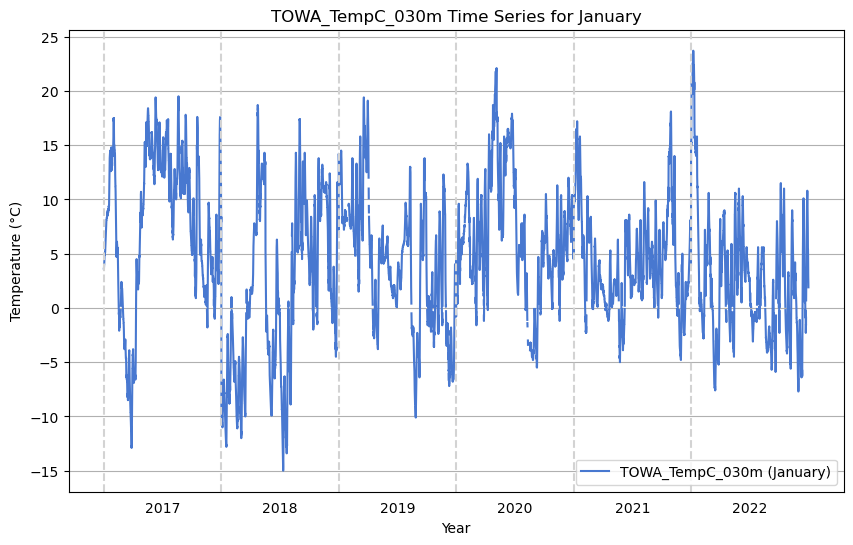

In [42]:
# Group by month
df = combined_df_2
grouped_df = df.groupby(df.index.month)
january_group = grouped_df.get_group(1)  # 1 corresponds to January
series = january_group['TOWA_TempC_030m']

# Generate a continuous range for the x-axis
x = range(len(series.index))

# Extract the years from the index
years = series.index.year

# Create x-ticks for the first occurrence of each year
unique_years = np.unique(years)
year_ticks = [np.where(years == year)[0][0] for year in unique_years]

# Calculate positions for the year labels to be between ticks
year_label_positions = [(year_ticks[i] + year_ticks[i + 1]) / 2 for i in range(len(year_ticks) - 1)]
# Add a label for the last year
year_label_positions.append(year_ticks[-1] + (len(x) - year_ticks[-1]) / 2)

# Plot the series for January
sns.set_palette("muted")
plt.figure(figsize=(10, 6))
plt.plot(x, series, label='TOWA_TempC_030m (January)')
plt.title('TOWA_TempC_030m Time Series for January')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

# Set x-ticks for gridlines at year boundaries
plt.grid(axis='y')
plt.xticks(year_label_positions, unique_years, rotation=0)
plt.tick_params(axis='x', which='both', bottom=False)

# Add vertical gridlines at the year boundaries
for tick in year_ticks:
    plt.axvline(x=tick, color='lightgrey', linestyle='--')

plt.legend()
plt.show()

### 6.b. Group by seasons (i.e., years)
The goal of Mann-Kendall is to see how a timeseries changes over the "seasons." In our case, we want to see how a month changes over the years. So, we have 6 seasons: 2017, 2018, 2019, 2020, 2021, 2022. We will run the Mann-Kendall test on each month to see how the months change over time.

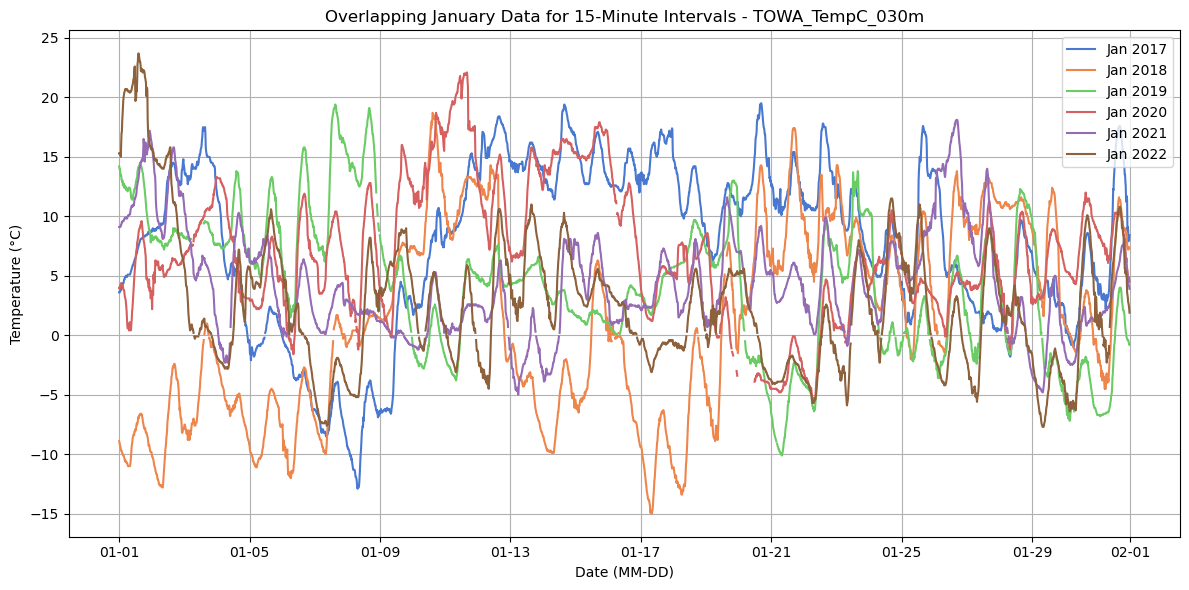

In [26]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Filter the columns for the 'TOWA' tower and the 'TempC' variable
towa_temp_columns = january_df.columns[january_df.columns.str.contains('TOWA') & january_df.columns.str.contains('TempC')]
january_towa_temp_df = january_df[towa_temp_columns]

# Use the muted color palette from Seaborn
palette = sns.color_palette("muted", len(january_towa_temp_df.index.year.unique()))

# Example plotting for one specific tower/height combination
tower_variable_height = towa_temp_columns[0]  # Use the first TOWA TempC column as an example

# Plot the data for each year on the same x-axis without the year information
plt.figure(figsize=(12, 6))

# Loop through each year, align the dates to remove the year for stacking, and plot
for i, year in enumerate(sorted(january_towa_temp_df.index.year.unique())):
    yearly_data = january_towa_temp_df[january_towa_temp_df.index.year == year].copy()
    yearly_data.index = yearly_data.index.map(lambda x: x.replace(year=2000))  # Align years to 2000
    plt.plot(yearly_data.index, yearly_data[tower_variable_height], label=f'Jan {year}', color=palette[i])

# Format the x-axis to show only the month and day
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

# Labels and title
plt.title(f'Overlapping January Data for 15-Minute Intervals - {tower_variable_height}')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.c. Pairwise comparisons
For each month, and every timestamp of that month, do a pairwise comparison across all the seasons (years)

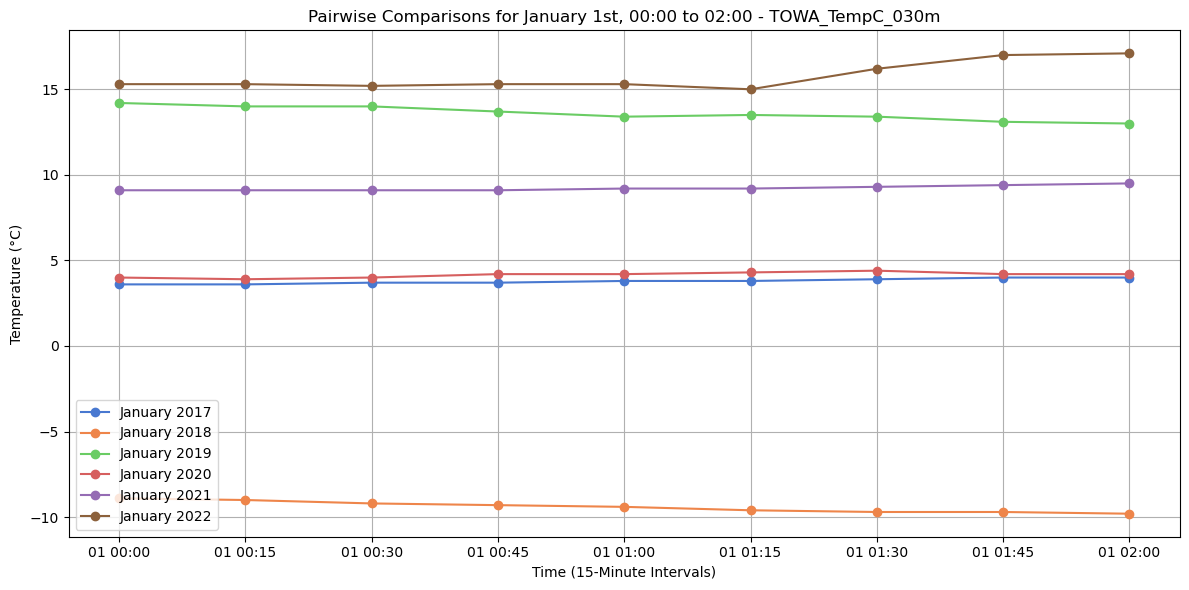

In [29]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Filter the columns for the 'TOWA' tower and the 'TempC' variable
towa_temp_columns = january_df.columns[january_df.columns.str.contains('TOWA') & january_df.columns.str.contains('TempC')]
january_towa_temp_df = january_df[towa_temp_columns]

# Align the dates to remove the year for stacking (this makes the x-axis comparable across years)
stacked_data = []
for year in sorted(january_towa_temp_df.index.year.unique()):
    year_data = january_towa_temp_df[january_towa_temp_df.index.year == year].copy()
    year_data.index = year_data.index.map(lambda x: x.replace(year=2000))
    stacked_data.append(year_data.assign(Year=year))  # Assign year for later use

# Combine the stacked data
stacked_january_df = pd.concat(stacked_data).sort_index()

# Let's zoom in to two hours of data (for example, 1st January from 00:00 to 02:00)
start_time = '2000-01-01 00:00'
end_time = '2000-01-01 02:00'

# Filter the data for this two-hour period
stacked_january_zoom = stacked_january_df.loc[start_time:end_time]

# Example plotting for one specific tower/height combination
tower_variable_height = towa_temp_columns[0]  # Use the first TOWA TempC column as an example

# Plotting
plt.figure(figsize=(12, 6))
palette = sns.color_palette("muted", len(january_towa_temp_df.index.year.unique()))
# Plot the data for each year in this two-hour window in sorted order
for i, year in enumerate(sorted(stacked_january_zoom['Year'].unique())):
    year_data = stacked_january_zoom[stacked_january_zoom['Year'] == year]
    plt.plot(year_data.index, year_data[tower_variable_height], 'o-', label=f'January {year}', color=palette[i])

# Labels and title
plt.title(f'Pairwise Comparisons for January 1st, 00:00 to 02:00 - {tower_variable_height}')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.d. Pairwise differences
Calculate the pairwise differences (a positive difference means upward trend; a negative difference means downward trend)

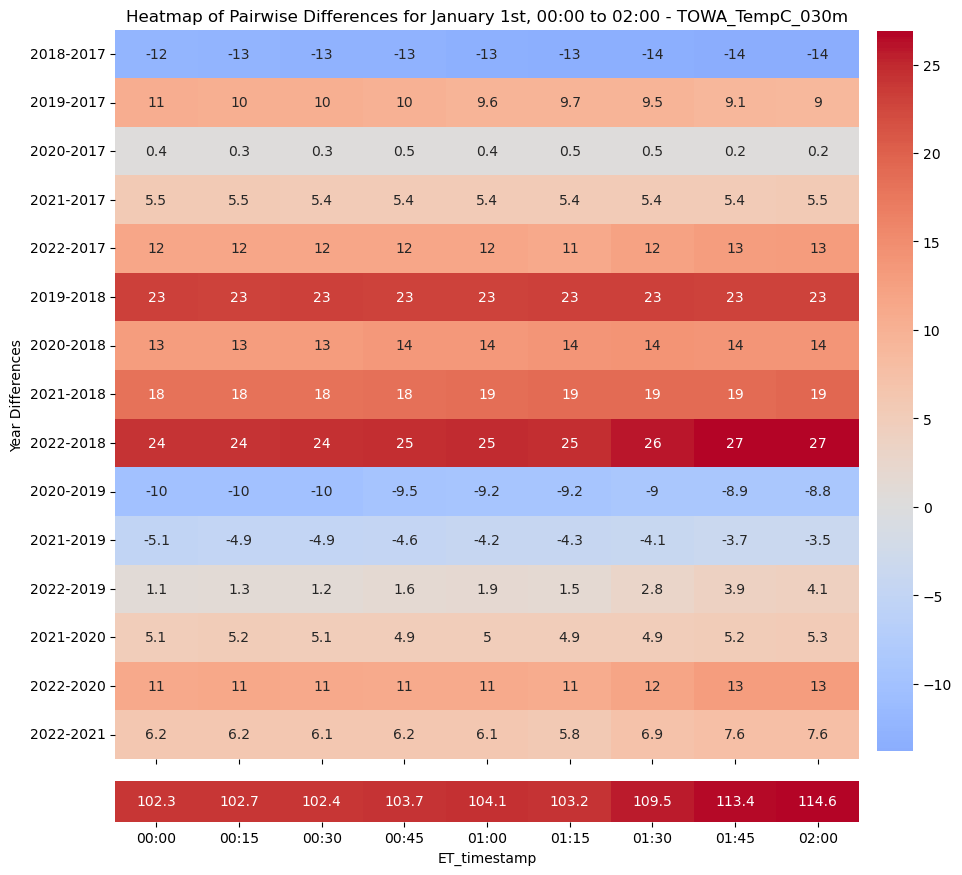

In [35]:
# Initialize a DataFrame to store the pairwise differences
pairwise_diffs = pd.DataFrame(index=stacked_january_zoom.index.unique())

# Calculate pairwise differences and store them in the DataFrame
for year1 in sorted(stacked_january_zoom['Year'].unique()):
    for year2 in sorted(stacked_january_zoom['Year'].unique()):
        if year1 < year2:
            diff_label = f'{year2}-{year1}'
            value1 = stacked_january_zoom[stacked_january_zoom['Year'] == year1][tower_variable_height]
            value2 = stacked_january_zoom[stacked_january_zoom['Year'] == year2][tower_variable_height]
            
            # Calculate the difference and add it to the DataFrame
            pairwise_diffs[diff_label] = value2.values - value1.values

# Format the index to show only the time in HH:MM format
pairwise_diffs.index = pairwise_diffs.index.strftime('%H:%M')
n_rows = len(pairwise_diffs) * 2

# Calculate the sum of pairwise differences for each time point
sum_diffs = pairwise_diffs.sum(axis=1)

# Create a figure with subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, n_rows * 0.5 + 2), gridspec_kw={'height_ratios': [n_rows, 1]}, constrained_layout=False, sharex=True)

# First subplot: Heatmap of pairwise differences
sns.heatmap(pairwise_diffs.T, annot=True, cmap='coolwarm', center=0, ax=ax1, cbar_kws={'shrink': 0.5})
ax1.set_title(f'Heatmap of Pairwise Differences for January 1st, 00:00 to 02:00 - {tower_variable_height}')
ax1.set_xlabel('')  # Remove x-axis label for the top heatmap
ax1.set_ylabel('Year Differences')

# Adjust the position of the colorbar to bring it closer to the plot
cbar = ax1.collections[0].colorbar
cbar.ax.set_position([.76, .223, .03, .657])  # Moving the colorbar closer

# Second subplot: Heatmap of the sum of pairwise differences
sns.heatmap(sum_diffs.to_frame().T, annot=True, fmt='.1f', cmap='coolwarm', center=0, cbar=False, ax=ax2)

# Remove y-axis ticks, tick labels, and the label itself
ax2.set_ylabel('')
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_yticklabels([])  # Remove y-axis tick labels

# Move the bottom heatmap closer to the top heatmap
pos1 = ax1.get_position()
pos2 = ax2.get_position()
ax2.set_position([pos1.x0, pos2.y0 + 0.05, pos1.width, pos2.height])  # Adjust y0 to move it up

plt.show()

### 6.e.1 Sum of S-statistic (zoomed in)
Determine the overall trend direction by summing all of the positive and negative pairwise differences

/tmp/ipykernel_10200/2750873340.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_statistic[i] = np.sum(np.sign(subset_series[i] - subset_series[:i]))


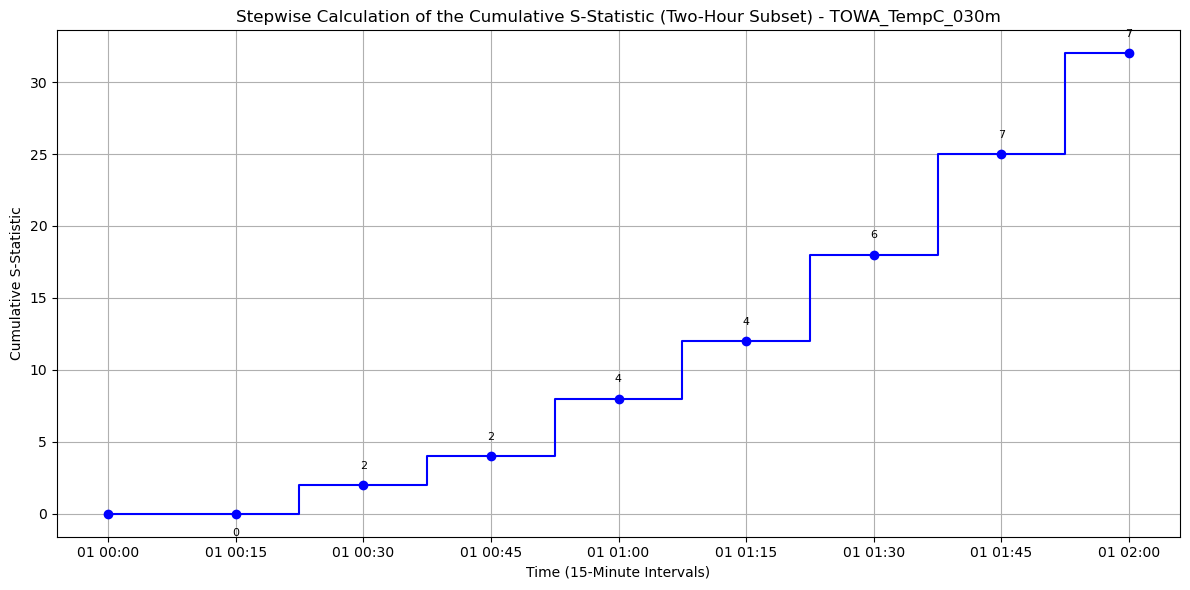

In [36]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Step 1: Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Step 2: Select the specific column for 'TOWA_TempC_030m'
series = january_df['TOWA_TempC_030m']

# Step 3: Select a two-hour subset of the data (e.g., 1st January from 00:00 to 02:00)
start_time = '2017-01-01 00:00'
end_time = '2017-01-01 02:00'
subset_series = series[start_time:end_time]

# Calculate the S-statistic for each time point in the subset
s_statistic = np.zeros(len(subset_series))
for i in range(1, len(subset_series)):
    s_statistic[i] = np.sum(np.sign(subset_series[i] - subset_series[:i]))

# Calculate the cumulative sum of the S-statistic
cumulative_s_stat = np.cumsum(s_statistic)

# Plot the cumulative sum of the S-statistic
plt.figure(figsize=(12, 6))
plt.step(subset_series.index, cumulative_s_stat, label='Cumulative S-Statistic', where='mid', color='blue', marker='o')

# Annotate the steps with adjusted positions to avoid overlapping with the line
for i in range(1, len(subset_series)):
    y_offset = 1 if s_statistic[i] > 0 else -1  # Adjust y_offset to move annotations slightly above/below the line
    plt.text(subset_series.index[i], cumulative_s_stat[i] + y_offset, f'{int(s_statistic[i])}', 
             ha='center', va='bottom' if s_statistic[i] > 0 else 'top', fontsize=8)

# Labels and title
plt.title('Stepwise Calculation of the Cumulative S-Statistic (Two-Hour Subset) - TOWA_TempC_030m')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Cumulative S-Statistic')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.e.2. Sum of S-Statistic (across all seasons)

/tmp/ipykernel_10200/1632112684.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))


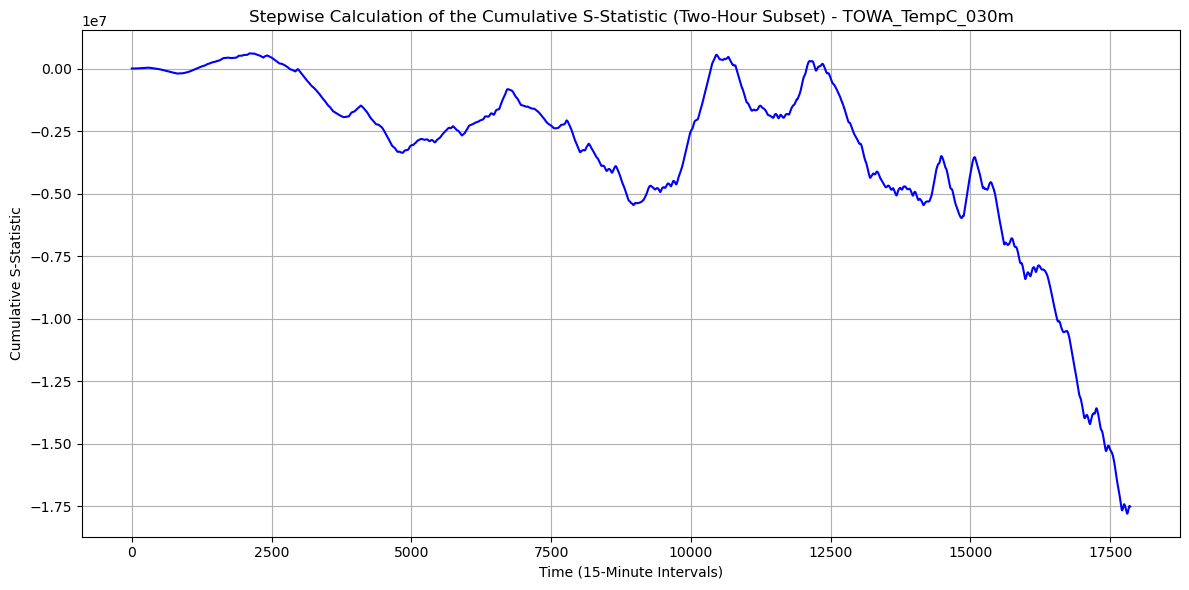

In [37]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Step 1: Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Step 2: Select the specific column for 'TOWA_TempC_030m'
series = january_df['TOWA_TempC_030m']

# Calculate the S-statistic for each time point in the subset
s_statistic = np.zeros(len(series))
for i in range(1, len(series)):
    s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))

# Calculate the cumulative sum of the S-statistic
cumulative_s_stat = np.cumsum(s_statistic)

# Plot the cumulative sum of the S-statistic
plt.figure(figsize=(12, 6))
plt.plot(range(len(series)), cumulative_s_stat, label='Cumulative S-Statistic', color='blue')

# Labels and title
plt.title('Stepwise Calculation of the Cumulative S-Statistic (Two-Hour Subset) - TOWA_TempC_030m')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Cumulative S-Statistic')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.e.3. Compare sum of S-Statistic across all seasons for each tower-variable-height

/tmp/ipykernel_10200/460805477.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))


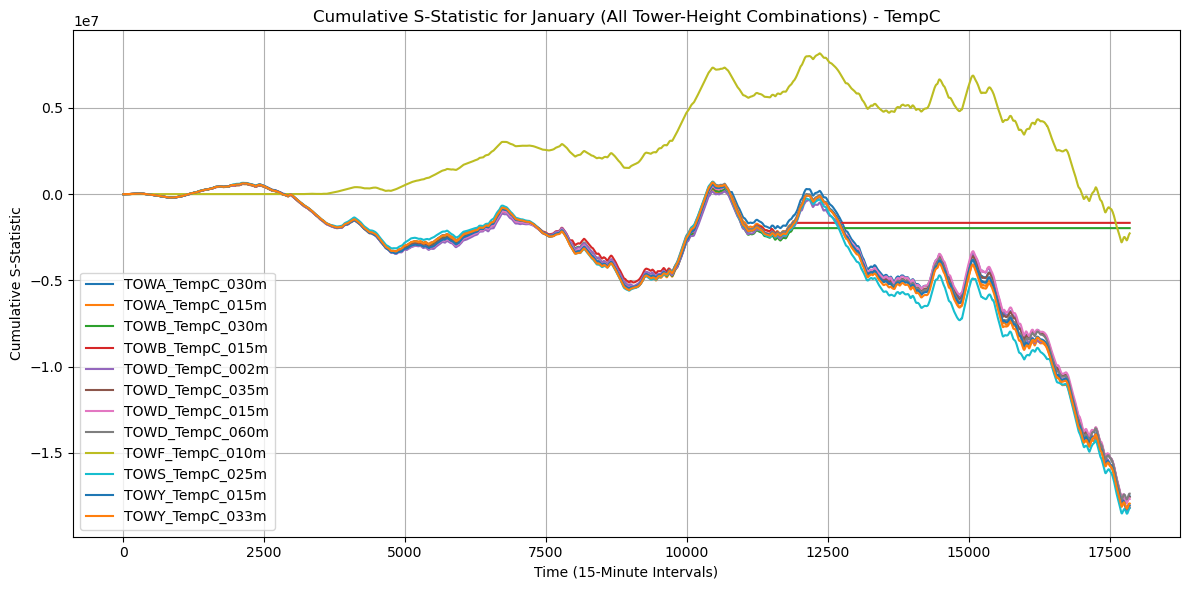

In [38]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Step 1: Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Step 2: Filter columns that contain 'TempC' to get all tower-height combinations
temp_columns = january_df.columns[january_df.columns.str.contains('TempC')]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Loop through each 'TempC' tower-height combination
for column in temp_columns:
    series = january_df[column]
    
    # Calculate the S-statistic for each time point in the series
    s_statistic = np.zeros(len(series))
    for i in range(1, len(series)):
        s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))
    
    # Calculate the cumulative sum of the S-statistic
    cumulative_s_stat = np.cumsum(s_statistic)
    
    # Plot the cumulative sum of the S-statistic for the current tower-height combination
    plt.plot(range(len(series)), cumulative_s_stat, label=column)

# Labels and title
plt.title('Cumulative S-Statistic for January (All Tower-Height Combinations) - TempC')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Cumulative S-Statistic')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

---
---
# 7. Perform the Mann-Kendall Test

In [7]:
from dask.distributed import Client

# Configure Dask Client
client = Client(
    n_workers=16,  # Number of workers, leaving some cores free
    threads_per_worker=1,  # One thread per worker
    memory_limit='3GB'  # Adjust based on your system's total memory; 4GB is a reasonable start
)

print(client.dashboard_link)

http://127.0.0.1:8787/status


## 7.a. Mann-Kendall

In [43]:
# Assuming `combined_df_2` is your original Pandas DataFrame
df = combined_df_2
num_years = len(df.index.year.unique())

# Function to apply seasonal MK test on a Pandas Series
def apply_seasonal_mk(series):
    # Ensure the series has enough data points
    if series.dropna().shape[0] < 12:  # Less than one full year of data
        return pd.Series({'trend': None, 'p': None, 'z': None, 's': None, 'var_s': None})

    try:
        result = seasonal_test(series, period=num_years)  # Assuming monthly seasonality
        return pd.Series({'trend': result.trend, 'p': result.p, 'z': result.z, 's': result.s, 'var_s': result.var_s})
    except ZeroDivisionError:
        return pd.Series({'trend': None, 'p': None, 'z': None, 's': None, 'var_s': None})

# Group by month
grouped_df = df.groupby(df.index.month)

# Initialize a counter to track progress
total_groups = len(grouped_df)
counter = 0

# Define a function that processes each group
def process_group(name, group, counter, total_groups):
    print(f"Processing group {counter + 1} of {total_groups} (Month: {name})")
    result = group.apply(apply_seasonal_mk, axis=0)
    result['month'] = name  # Add the month information as a new column
    return result

# Apply the seasonal MK test in parallel
delayed_tasks = []
for counter, (name, group) in enumerate(grouped_df):
    # Create a delayed object for each group processing
    task = delayed(process_group)(name, group, counter, total_groups)
    delayed_tasks.append(task)

# Compute all tasks in parallel
results = compute(*delayed_tasks)

# Convert results to the desired format (e.g., concatenate into a DataFrame)
final_mk_results = pd.concat(results)

/home/6ru/anaconda3/envs/nsrd/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 78.63 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2024-09-12 16:02:59,388 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.72 GiB -- Worker memory limit: 3.73 GiB
2024-09-12 16:02:59,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-me

In [45]:
final_mk_results.head(5)

,TOWA_TempC_030m,TOWA_TempC_015m,TOWA_RelHum_015m,TOWA_AbsHum_015m,TOWA_WSpdMph_030m,TOWA_WSpdMph_015m,TOWA_PkWSpdMph_030m,TOWA_PkWSpdMph_015m,TOWA_VSSpdMph_015m,TOWA_VSSpdMph_030m,...,TOWY_VSSpdMph_033m,TOWY_SolarRadWm2_015m,TOWY_BarPresMb_015m,TOWY_Sigma_015m,TOWY_Sigma_033m,TOWY_SigPhi_015m,TOWY_SigPhi_033m,TOWY_WDir_033m,TOWY_PrecipIn_015m,month
trend,decreasing,decreasing,decreasing,decreasing,no trend,increasing,increasing,increasing,increasing,increasing,...,decreasing,no trend,decreasing,decreasing,decreasing,decreasing,decreasing,decreasing,no trend,1
p,0.0,0.0,0.012583,0.0,0.995431,0.000003,0.000001,0.000007,0.0,0.006228,...,0.000668,0.108488,0.0,0.0,0.0,0.030698,0.0,0.0,0.83463,1
z,-22.352919,-23.290673,-2.495369,-16.386969,0.005727,4.653602,4.913169,4.479729,5.84218,2.735528,...,-3.402388,1.605026,-16.583559,-6.826667,-9.8331,-2.16096,-6.111683,-5.31674,-0.208767,1
s,-2917332.0,-3024022.0,-318766.0,-2067973.0,572.0,607124.0,639862.0,580882.0,757825.0,358106.0,...,-442213.0,190180.0,-2168237.0,-903695.0,-1302330.0,-282865.0,-794317.0,-704221.0,-11470.0,1
var_s,17033461815.333332,16857980353.999998,16318176988.0,15925461829.666666,9941264476.666668,17020598519.999998,16960863546.666668,16813991280.666666,16826228549.666668,17137146041.999998,...,16892476793.666668,14039808755.999998,17094548428.333334,17523679930.333332,17541247268.666664,17134124854.333334,16891372452.333336,17543886421.0,3018065152.666667,1


In [46]:
# Assuming final_results is your DataFrame
sub_tables = []

# Define the significance threshold
significance_threshold = 0.05

# Define the number of decimal places to round to
rounding_decimals = 3

# Extract unique variables by stripping the tower and height parts from the columns
variables = sorted(list(set([col.split('_')[1] for col in final_mk_results.columns if col != 'month'])))

# Iterate over each unique month in the DataFrame
for month in final_mk_results['month'].unique():
    for variable in variables:
        # Extract columns related to the current variable
        related_columns = sorted([col for col in final_mk_results.columns if variable in col.split('_')])
        
        # Filter the DataFrame for the current month
        mask = (final_mk_results['month'] == month)
        filtered_df = final_mk_results.loc[mask]
        
        # Extract the tau and p-value rows
        tau_values = filtered_df.loc['trend', related_columns].values
        p_values = filtered_df.loc['p', related_columns].values
        
        # Round p-values and add an asterisk if below the significance threshold
        p_values_with_significance = [
            f"{round(p, rounding_decimals)}*" if p is not None and not np.isnan(p) and p < significance_threshold 
            else f"{round(p, rounding_decimals)}" if p is not None and not np.isnan(p)
            else "NaN"
            for p in p_values
        ]
        
        # Create a sub-table
        sub_table = pd.DataFrame({
            'tower_variable_height': related_columns,
            'month': [month] * len(related_columns),
            'tau': tau_values,
            'p-value': p_values_with_significance
        })
        
        # Add the sub-table to the list
        sub_tables.append(sub_table)

# sub_tables now contains a list of DataFrames, each representing a variable-month combination

In [47]:
all_subtables = pd.concat(sub_tables, axis=0)
all_subtables

,tower_variable_height,month,tau,p-value
0,TOWA_AbsHum_015m,1,decreasing,0.0*
1,TOWD_AbsHum_002m,1,decreasing,0.0*
2,TOWD_AbsHum_015m,1,decreasing,0.0*
3,TOWF_AbsHum_010m,1,increasing,0.0*
0,TOWA_BarPresMb_015m,1,decreasing,0.0*
...,...,...,...,...
6,TOWD_WSpdMph_060m,12,decreasing,0.003*
7,TOWF_WSpdMph_010m,12,decreasing,0.0*
8,TOWS_WSpdMph_025m,12,decreasing,0.0*
9,TOWY_WSpdMph_015m,12,decreasing,0.0*


## 7.b. Sen's slope

In [49]:
# Assuming `combined_df_2` is your original Pandas DataFrame
df = combined_df_2
num_years = len(df.index.year.unique())

# Function to apply seasonal Sen's slope on a Pandas Series
def apply_seasonal_sens_slope(series):
    # Ensure the series has enough data points
    if series.dropna().shape[0] < 12:  # Less than one full year of data
        return pd.Series({'slope': None, 'intercept': None})

    try:
        # Convert the series to a NumPy array before passing it to the function
        result = seasonal_sens_slope(series.to_numpy(), period=num_years)  # Assuming monthly seasonality
        return pd.Series({'slope': result.slope, 'intercept': result.intercept})
    except ZeroDivisionError:
        return pd.Series({'slope': None, 'intercept': None})

# Group by month
grouped_df = df.groupby(df.index.month)

# Initialize a counter to track progress
total_groups = len(grouped_df)
counter = 0

# Define a function that processes each group
def process_group(name, group, counter, total_groups):
    print(f"Processing group {counter + 1} of {total_groups} (Month: {name})")
    result = group.apply(apply_seasonal_sens_slope, axis=0)
    result['month'] = name  # Add the month information as a new column
    return result

# Apply the seasonal Sen's slope calculation in parallel
delayed_tasks = []
for counter, (name, group) in enumerate(grouped_df):
    # Create a delayed object for each group processing
    task = delayed(process_group)(name, group, counter, total_groups)
    delayed_tasks.append(task)

# Compute all tasks in parallel
results = compute(*delayed_tasks)

# Convert results to the desired format (e.g., concatenate into a DataFrame)
final_sens_slope_results = pd.concat(results)

/home/6ru/anaconda3/envs/nsrd/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 78.62 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2024-09-12 16:17:01,603 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2024-09-12 16:17:02,538 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2024-09-12 16:17:02,546 - distributed.worker.memory -

In [50]:
final_sens_slope_results.head(2)

,TOWA_TempC_030m,TOWA_TempC_015m,TOWA_RelHum_015m,TOWA_AbsHum_015m,TOWA_WSpdMph_030m,TOWA_WSpdMph_015m,TOWA_PkWSpdMph_030m,TOWA_PkWSpdMph_015m,TOWA_VSSpdMph_015m,TOWA_VSSpdMph_030m,...,TOWY_VSSpdMph_033m,TOWY_SolarRadWm2_015m,TOWY_BarPresMb_015m,TOWY_Sigma_015m,TOWY_Sigma_033m,TOWY_SigPhi_015m,TOWY_SigPhi_033m,TOWY_WDir_033m,TOWY_PrecipIn_015m,month
slope,-0.001412,-0.001478,-0.000339,-0.000424,0.0,0.000074,0.000226,0.000177,0.000005,0.0,...,-0.000007,0.0,-0.001117,-0.000404,-0.000524,-0.000076,-0.000231,-0.002165,0.0,1
intercept,6.493412,6.488504,76.195620,5.120962,4.2,2.890795,7.667463,6.340646,-0.067854,0.0,...,-0.028477,0.0,987.991097,17.001416,14.679203,8.111759,10.740088,217.220550,0.0,1


In [52]:
# Assuming final_results is your DataFrame
sub_tables_2 = []

# Define the number of decimal places to round to
rounding_decimals = 3

# Extract unique variables by stripping the tower and height parts from the columns
variables = sorted(list(set([col.split('_')[1] for col in final_sens_slope_results.columns if col != 'month'])))

# Iterate over each unique month in the DataFrame
for month in final_sens_slope_results['month'].unique():
    for variable in variables:
        # Extract columns related to the current variable
        related_columns = sorted([col for col in final_sens_slope_results.columns if variable in col.split('_')])
        
        # Filter the DataFrame for the current month
        mask = (final_sens_slope_results['month'] == month)
        filtered_df = final_sens_slope_results.loc[mask]
        
        # Extract the tau and p-value rows
        slope_values = filtered_df.loc['slope', related_columns].values
        int_values = filtered_df.loc['intercept', related_columns].values
        
        # Create a sub-table
        sub_table = pd.DataFrame({
            'tower_variable_height': related_columns,
            'month': [month] * len(related_columns),
            'sens_slope': slope_values,
            'sens_slope_intercept': int_values
        })
        
        # Add the sub-table to the list
        sub_tables_2.append(sub_table)

# sub_tables now contains a list of DataFrames, each representing a variable-month combination

In [53]:
all_subtables_wsens = pd.concat(sub_tables_2)

In [54]:
all_subtables_wsens

,tower_variable_height,month,sens_slope,sens_slope_intercept
0,TOWA_AbsHum_015m,1,-0.000424,5.120962
1,TOWD_AbsHum_002m,1,-0.000389,4.978447
2,TOWD_AbsHum_015m,1,-0.000408,4.90347
3,TOWF_AbsHum_010m,1,0.000332,3.827089
0,TOWA_BarPresMb_015m,1,-0.000877,990.2092
...,...,...,...,...
6,TOWD_WSpdMph_060m,12,-0.000079,4.817504
7,TOWF_WSpdMph_010m,12,-0.000079,4.199802
8,TOWS_WSpdMph_025m,12,-0.000231,6.843755
9,TOWY_WSpdMph_015m,12,-0.000232,3.946117


In [55]:
complete_results = pd.merge(left=all_subtables, right=all_subtables_wsens, on=['tower_variable_height', 'month'])
complete_results['sens_slope'] = round(complete_results['sens_slope'], 3)
complete_results['sens_slope_intercept'] = round(complete_results['sens_slope_intercept'], 3)
complete_results

,tower_variable_height,month,tau,p-value,sens_slope,sens_slope_intercept
0,TOWA_AbsHum_015m,1,decreasing,0.0*,-0.000424,5.120962
1,TOWD_AbsHum_002m,1,decreasing,0.0*,-0.000389,4.978447
2,TOWD_AbsHum_015m,1,decreasing,0.0*,-0.000408,4.90347
3,TOWF_AbsHum_010m,1,increasing,0.0*,0.000332,3.827089
4,TOWA_BarPresMb_015m,1,decreasing,0.0*,-0.000877,990.2092
...,...,...,...,...,...,...
1147,TOWD_WSpdMph_060m,12,decreasing,0.003*,-0.000079,4.817504
1148,TOWF_WSpdMph_010m,12,decreasing,0.0*,-0.000079,4.199802
1149,TOWS_WSpdMph_025m,12,decreasing,0.0*,-0.000231,6.843755
1150,TOWY_WSpdMph_015m,12,decreasing,0.0*,-0.000232,3.946117


In [56]:
complete_results.to_csv('../eda_results/mk_theilsen_results.csv', index=False)

## Monthly sen's slope distributions (example; not working code)

In [ ]:
# dfs = []
# for df, tower_name in zip(tower_dfs_15m_clean, towers_of_interest):
#     df = df.rename(columns=lambda x: f"{tower_name}_{x}")
#     dfs.append(df)
# combined_df_2 = pd.concat(dfs, axis=1)
# combined_df_2 = combined_df_2.astype(np.float32)

# # Add month and year columns
# combined_df_2['Year'] = combined_df_2.index.year
# combined_df_2['Month'] = combined_df_2.index.month

# # Group by Year and Month and calculate statistics
# monthly_stats = combined_df_2.groupby(['Year', 'Month']).agg(['max', 'min', 'mean', 'median'])

# # Function to apply Theil-Sen regression for each group
# def apply_theilslopes_group(df):
#     results = {}
#     for name, group in df.groupby('Month'):  # Group by Month
#         ordinal_index = pd.to_datetime(group.index.get_level_values('Year'), format='%Y').map(pd.Timestamp.toordinal)
#         for col in df.columns.levels[0]:  # Iterate over tower_variable_height columns
#             for stat in ['max', 'min', 'mean', 'median']:  # Iterate over each statistic
#                 data = group[(col, stat)]
#                 slope, intercept, _, _ = theilslopes(data, ordinal_index)
#                 results[(col, stat, name)] = (slope, intercept)
#     return pd.DataFrame(results)

# # Apply the function to the DataFrame
# theilslopes_results = apply_theilslopes_group(monthly_stats)

# # Transpose the DataFrame for easier manipulation
# theilslopes_results = theilslopes_results.T
# theilslopes_results.columns = ['Slope', 'Intercept']
# theilslopes_results.index.names = ['tower_variable_height', 'Statistic', 'Month']

# # Extract the variable names (e.g., TempC, BarPresMb) from the tower_variable_height column
# theilslopes_results['Variable'] = theilslopes_results.index.get_level_values('tower_variable_height').str.split('_').str[1]

# # Reset index to have a flat DataFrame
# theilslopes_results = theilslopes_results.reset_index()

# # Group by Variable, Statistic, and Month for plotting
# grouped_results = theilslopes_results.groupby(['Variable', 'Statistic', 'Month', 'tower_variable_height'])['Slope'].mean().reset_index()

# # Set the Seaborn color palette
# sns.set_palette('pastel')

# # Get the unique variables to create one plot for each
# variables = grouped_results['Variable'].unique()

# # Mapping month numbers to three-letter month abbreviations
# month_abbr = [calendar.month_abbr[i] for i in range(1, 13)]

# for variable in variables:
#     # Filter the data for the current variable
#     variable_data = grouped_results[grouped_results['Variable'] == variable]
    
#     # Set up the subplots
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#     fig.suptitle(f'Sen\'s Slope for {variable} by Month', fontsize=16, y=0.91)  # Adjusted suptitle position
    
#     # Define the statistics and corresponding axes
#     stats = ['min', 'max', 'mean', 'median']
#     ax_dict = {'min': axes[0, 0], 'max': axes[0, 1], 'mean': axes[1, 0], 'median': axes[1, 1]}
    
#     for stat in stats:
#         ax = ax_dict[stat]
#         # Filter data for the current statistic
#         stat_data = variable_data[variable_data['Statistic'] == stat]
        
#         # Create a boxplot with a red median line
#         sns.boxplot(x='Month', y='Slope', data=stat_data, ax=ax,
#                     medianprops={'color': 'red', 'linewidth': 1})
#         ax.set_title(f'{stat.capitalize()} {variable}')
        
#         # Align the x-axis labels with the actual boxplot positions
#         ax.set_xticks(ax.get_xticks())  # Ensure ticks match the boxplot positions
#         ax.set_xticklabels(month_abbr, ha='center')
        
#         # Calculate the positions for the dashed lines between the boxplots
#         ticks = ax.get_xticks()
#         midpoints = [(ticks[i] + ticks[i+1]) / 2 for i in range(len(ticks)-1)]
        
#         # Add light grey dashed lines at the midpoints
#         for midpoint in midpoints:
#             ax.axvline(x=midpoint, color='lightgrey', linestyle='--', linewidth=1)
        
#         # Only set y-axis labels on the left subplots
#         if stat in ['min', 'mean']:
#             ax.set_ylabel('Sen\'s Slope')
#         else:
#             ax.set_ylabel('')  # Remove y-axis label
        
#         # Remove the "Month" label from the x-axis
#         ax.set_xlabel('')
#         ax.tick_params(axis='x', bottom=False)  # Remove x-axis ticks
    
#     # Adjust layout
#     plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to fit the title better
#     plt.show()